In [1]:
import os
cwd = os.getcwd()
from PIL import ImageFile
import urllib2 as ul
import requests
import csv

ImageFile.LOAD_TRUNCATED_IMAGES = True
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from tensorflow.keras import Model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage import io, transform,img_as_float
from skimage.io import imread
from skimage.transform import rescale, resize
from tensorflow.keras.models import load_model
import numpy as np
import cv2
from sklearn.metrics import label_ranking_average_precision_score
import time


%matplotlib inline

## Get data

In [2]:
#!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1jLw6vhvkdKUQG6pESPBK9V5SW6bitV8f' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1jLw6vhvkdKUQG6pESPBK9V5SW6bitV8f" -O dataset && rm -rf /tmp/cookies.txt


In [3]:
#!tar -zxvf dataset

In [4]:
def get_data(h=400,w=400,limit=500):
    cwd = os.getcwd()
    #data = np.empty((h,w,3), float)
    data = []
    folder = cwd + "/dataset/"
    img_ids = next(os.walk(folder))[2]
  
    img_ids = img_ids[0:limit]
    for n,id_ in enumerate(img_ids):
        img = np.load(folder+id_)
        #img = img.astype('float32',copy = False)
       
       
        img = resize(img, (h,w))
        data.append(img)
        #data = np.append(data, img, axis=0)
       
    data = np.array(data)
    return data

In [5]:
limit = 300
data_np = get_data(h=200,w=200,limit=limit)


/opt/miniconda/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/miniconda/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [6]:
print data_np.shape

(300, 200, 200, 3)


In [7]:
n_img, img_h, img_w, n_channels = data_np.shape[0],data_np.shape[1], data_np.shape[2], data_np.shape[3]
print "Número de imágenes",n_img," Alto: ", img_h,"Ancho: ", img_w, "Canales",n_channels

Número de imágenes 300  Alto:  200 Ancho:  200 Canales 3


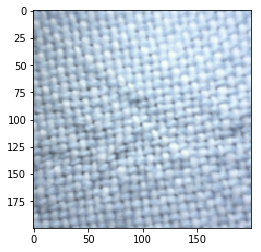

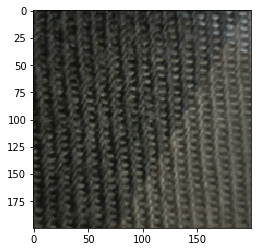

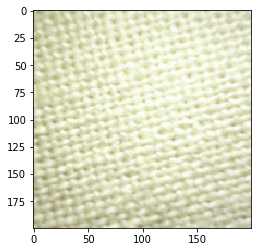

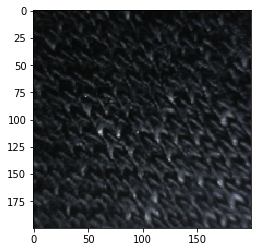

In [8]:
aux = 0
while(aux < 4):
    pos = np.random.randint(0, limit)
    plt.imshow(data_np[pos])
    plt.show()
    aux += 1
   

In [9]:
print np.amax(data_np)   
print data_np.dtype


1.0
float64


## Split data

In [10]:
x_train, x_test = train_test_split(data_np, test_size=0.30, random_state=42)


In [11]:
print "Shape train: ", x_train.shape
print "Shape test: ", x_test.shape

Shape train:  (210, 200, 200, 3)
Shape test:  (90, 200, 200, 3)


In [12]:
x_train = x_train.astype('float32',copy=False)
x_test = x_test.astype('float32') 

In [13]:
print "Train type: ",x_train.dtype, "  Test type:", x_test.dtype

Train type:  float32   Test type: float32


In [14]:
#x_train_norm_r = np.reshape(x_train_norm, (len(x_train_norm), 28, 28, 3))  # adapt this if using `channels_first` image data format
#x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format


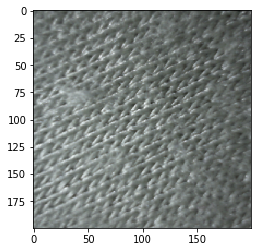

In [15]:
plt.imshow(x_train[1])

## Create noisy


In [16]:
def create_noisy(x_train,  img_h, img_w , n_channels,noise_factor=0.5):
   
    x_train_noisy = x_train.copy()
    x_train_noisy = np.array(x_train_noisy)
    n_xtrain = x_train_noisy.shape[0]
    
   
    for i in range(0,n_xtrain):
        img = x_train_noisy[i]

        w = np.random.randint(0,img_h-img_h*0.60)
        h=np.random.randint(0,img_h-img_h*0.70)
        bx,by = np.random.randint(img_w-w), np.random.randint(img_h-h)
        value = img[by:by+h,bx:bx+w,:]  + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=(h,w,n_channels)) 
        img[by:by+h,bx:bx+w,:] = value
        img = np.clip(img, 0., 1.)
    
    return x_train_noisy

   

In [17]:
x_train_noisy = create_noisy(x_train, img_h, img_w, n_channels )
print "Shape train noisy: ",x_train_noisy.shape
x_test_noisy = create_noisy(x_test, img_h, img_w, n_channels )
print "Shape test noisy: ",x_test_noisy.shape

Shape train noisy:  (210, 200, 200, 3)
Shape test noisy:  (90, 200, 200, 3)


In [18]:
print x_train_noisy.dtype

float32


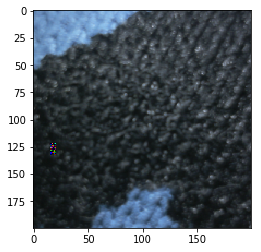

In [19]:
plt.imshow(x_train_noisy[4])

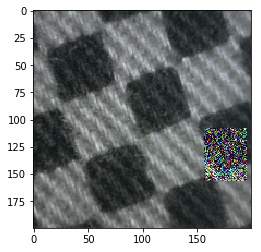

In [20]:
plt.imshow(x_test_noisy[12])

In [21]:
def train_model():
    input_img = Input(shape=(img_h, img_w, n_channels))  # adapt this if using `channels_first` image data format
    x = Conv2D(3, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same', name='encoder')(x)

    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(3, (1, 1), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    
    autoencoder.fit(x_train_noisy, x_train,
                    epochs=50,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_test_noisy, x_test)
                    #callbacks=[TensorBoard(log_dir='/tmp', histogram_freq=0, write_graph=False)]
                    )
    

    autoencoder.save('modelfabric.h5')

    return autoencoder


In [22]:
autoencoder = train_model()

Train on 210 samples, validate on 90 samples
Epoch 1/50
210/210 [==============================] - 17s 81ms/step - loss: 0.6935 - val_loss: 0.6934
Epoch 2/50
210/210 [==============================] - 8s 38ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 3/50
210/210 [==============================] - 8s 36ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 4/50
210/210 [==============================] - 8s 38ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 5/50
210/210 [==============================] - 7s 33ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 6/50
210/210 [==============================] - 7s 34ms/step - loss: 0.6929 - val_loss: 0.6930
Epoch 7/50
210/210 [==============================] - 7s 33ms/step - loss: 0.6928 - val_loss: 0.6929
Epoch 8/50
210/210 [==============================] - 7s 33ms/step - loss: 0.6926 - val_loss: 0.6927
Epoch 9/50
210/210 [==============================] - 7s 33ms/step - loss: 0.6925 - val_loss: 0.6924
Epoch 10/50
210/210 [========================

In [23]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 200, 3)       84        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 8)       224       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 8)         584       
_________________________________________________________________
encoder (MaxPooling2D)       (None, 25, 25, 8)         0         
__________

In [24]:
print (x_test_noisy.shape[0], x_test_noisy.shape[1], x_test_noisy.shape[2])

(90, 200, 200)


In [25]:
def plot_denoised_images():
    denoised_images = autoencoder.predict(x_test_noisy.reshape(x_test_noisy.shape[0], x_test_noisy.shape[1], x_test_noisy.shape[2],3))
    test_img = x_test_noisy[0]
   # plt.figure(figsize=(4,2))
    plt.figure(figsize=(20,5))
    plt.subplot(311)
    plt.imshow(test_img.reshape(400,400,3))
    plt.axis("off")
    #resized_test_img = cv2.resize(test_img, (280, 280))
    #cv2.imshow('input', resized_test_img)
    #cv2.waitKey(0)
    output = denoised_images[0]
    #plt.figure(figsize=(4,2))
    R= test_img[0]-denoised_images[0] 
    plt.subplot(312)
    plt.imshow( output.reshape(400,400,3))
    plt.axis("off")
    
    plt.subplot(313)
    plt.imshow( R.reshape(400,400,3))
    plt.axis("off")
    
    #resized_output = cv2.resize(output, (280, 280))
    #cv2.imshow('output', resized_output)
    #cv2.waitKey(0)

In [26]:
predic_images = autoencoder.predict(x_test_noisy.reshape(x_test_noisy.shape[0], x_test_noisy.shape[1], x_test_noisy.shape[2],3))


In [42]:
def plot_denoised_images_2(denoised_images):
    num_img = np.random.randint(0, x_test_noisy.shape[0])
    h = x_test_noisy.shape[1]
    w = x_test_noisy.shape[2]
    ch = x_test_noisy.shape[3]
    test_img = x_test_noisy[num_img]
   # plt.figure(figsize=(4,2))
    plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.imshow(test_img.reshape(h,w,ch))
    plt.title('Noisy image')
    plt.axis("off")
    #resized_test_img = cv2.resize(test_img, (280, 280))
    #cv2.imshow('input', resized_test_img)
    #cv2.waitKey(0)
    output = denoised_images[num_img]
    #plt.figure(figsize=(4,2))
    R= abs(output-test_img)
  
    plt.subplot(222)
    plt.imshow( output.reshape(h,w,ch))
    plt.title('Denoising image')
    plt.axis("off")
    
    plt.subplot(223)
    plt.imshow( R.reshape(h,w,ch), cmap=plt.cm.Greys_r)
    plt.title('Defect')
    plt.axis("off")
    
    R_reshaped = R[:,:,1:2]
    
    #R_reshaped = R.reshape((400, 400, ))
    print np.shape(R_reshaped)
    R_reshaped=np.array(R_reshaped*255, np.dtype('uint8'))
    ret, thresh = cv2.threshold ( R_reshaped, 127,255,0)
    im2, contornos, jerarquia = cv2.findContours (thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
   #for c in contornos:
    #   if cv2.contourArea(c) >= 5:
     #      posicion_x,posicion_y,ancho,alto = cv2.boundingRect(c) #Guardamos las dimensiones de la Bounding Box
      #     cv2.rectangle( test_img,(posicion_x,posicion_y),(posicion_x+ancho,posicion_y+alto),(255,0,0),2) #Dibujamos la bounding box sobre diff1
    cv2.drawContours(test_img,contornos, -1, (0,255,0), 3)
    plt.subplot(224)
    plt.imshow(  test_img.reshape(h,w,ch))
    plt.title('Defect Contour')
    plt.axis("off")
    #contours,_ = cv2.findContours( R,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    #imagen_gris = cv2.cvtColor( R, cv2.COLOR_BGR2GRAY)
    #resized_outpu  = cv2.resize(output, (280, 280))
    #cv2.imshow('output', resized_output)
    #cv2.waitKey(0)

(200, 200, 1)


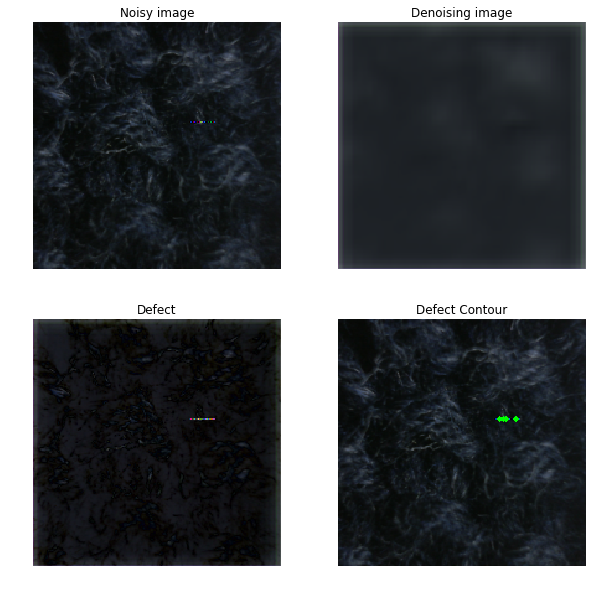

In [43]:
plot_denoised_images_2(predic_images)

### Entrenamiento con 50 imágenes

![alt text](50img.png "Entrenamiento con 50 imágenes")
